# PLR初期設定

PLRのアイテムをJupyter Notebookで処理するためには、本NotebookにしたがってPLR初期設定を実施する必要があります。

この操作は https://jupyterhub.cogtask.me/ にて環境起動後初回のみ実施する必要があります。1度実行すれば、再度実行する必要はありません。

以下のCellを1つ1つ実行し、PLRの設定を行なってください。**順番を間違ってしまった場合などは、再度先頭からCellを実行**してみてください。

セルの実行は以下のボタンから実施できます。

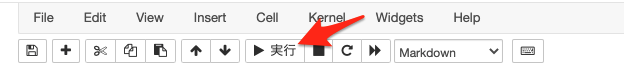

In [ ]:
print('試しにこのCellを実行してみてください。') # ↓にこの文字列が出力されます。

# PLRアカウントの初期設定

以下のセルを実行すると、URLが表示されるので、ブラウザで開いてください。ブラウザでPersonaryに登録したGoogleアカウントで認証を行うと、http://localhost:40385/... というURLが表示されるので、これを入力欄に貼り付けてください。

**セル下の補足**も参考にしてください。

In [ ]:
import pexpect

plrcommand = 'plr'
plrcui = pexpect.spawn(plrcommand + " storage new googleDrive")
plrcui.expect(r'\s+https://accounts.google.com/.*')
print(plrcui.after.decode('utf8').strip())

callback_url = input('↑のURLをクリックし、Googleアカウントで認証・操作の許可を行ってください。その後、ブラウザに表示されたURLを貼り付けてください。')
!curl -X GET "{callback_url}"
print('`Failed to connect to localhost`などのエラーメッセージが表示されなければ成功です。先に進めてください。')


> **補足1** ブラウザ画面にはエラーが表示されますが問題ありません。
>
> 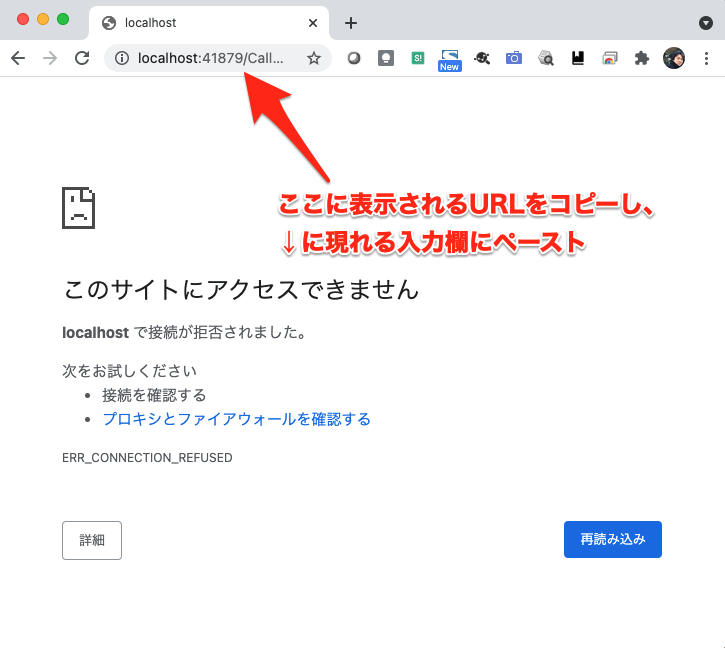

> **補足2** 事前にPersonaryアプリでご自身のPLRリポジトリを設定する必要があります。

PLRのパスフレーズを入力する。Personary設定時に指定したパスフレーズを以下に指定してください。

> パスフレーズ入力後、しばらく時間がかかります。

In [ ]:
import re
from getpass import getpass

passphrase = getpass('パスフレーズを入力してください。')
plrcui.expect('Enter passphrase:')
storage_id = [re.match(r'.*Storage created:\s*([0-9]+):.*', line).group(1) for line in plrcui.before.decode('utf8').splitlines() if re.match(r'.*Storage created:\s*([0-9]+):.*', line)][0]
plrcui.sendline(passphrase)
plrcui.expect('# ')
print('パスフレーズを設定しました。')

エラーとならなければ、これで設定は終了。

得られた設定を設定ファイルに書き出す。

In [ ]:
import os

plrcui.sendline('exit')
plrcui.expect('Exiting... done.')

with open(os.path.expanduser('~/.plrprofile'), 'w') as f:
    f.write('''export STORAGE_ID={storage_id}
export PASSPHRASE="{passphrase}"'''.format(**locals()))

PLRデータ取得サービスを起動する。念のため、現在の状態を確認しておく。

In [ ]:
if not os.path.exists(os.path.expanduser('~/.groovy/lib')):
    !mkdir -p ~/.groovy
    !ln -s /opt/plrfs/lib ~/.groovy/lib
!supervisorctl -s http://localhost:9001 status

PLRサービスを起動する。起動するまで待機しますのでしばらく待ってください。

> 1行目で `plrfs: ERROR (not running)` と表示される場合がありますが、無視してください。

In [ ]:
import time

!supervisorctl -s http://localhost:9001 restart plrfs

timeout = 10

# 起動完了するまで待つ
while timeout > 0:
    result = !supervisorctl -s http://localhost:9001 status plrfs
    if result[0].split()[1] == 'RUNNING':
        break
    time.sleep(10)
    timeout -= 1
assert timeout > 0, 'Timeoutしました。'
print('起動しました。')
!supervisorctl -s http://localhost:9001 status

In [ ]:
# 問題が発生した場合は以下のコマンドをコメントアウトしてログを取得、報告してください。
# !cat /tmp/supervisor-plrfs.log

# 動作確認

PLRのデータは `plrfs` モジュールを使って取得することができます。

モジュールの初期化は以下のように行います。

In [ ]:
import asyncio
from plrfs.rpc_client import PLRFSClient

loop = asyncio.get_event_loop()

以下は cogtask.me のために作成されたチャンネル情報を取得する例です。

> 実行状態が `[*]` のまま先に進まない場合は 中断(■) を押して一旦中断し、再度実行してみてください。

In [ ]:
client = await PLRFSClient(loop).connect()

channels = await client.get_files([])
for ch in channels:
    print('Channel', ch['name'])
cogtask_me_chs = [c for c in channels if c['name'] == 'cog-pds-log']
assert len(cogtask_me_chs) > 0, 'cogtask.meのチャンネルが見つかりません。'
cogtask_me_ch = cogtask_me_chs[0]
cogtask_me_ch

データの取得は以下のように行います。以下のセルを実行すると、Pandas https://pandas.pydata.org/ により表データを取得することができます。

In [ ]:
import json
import pandas as pd

timeline_item_data = []
# チャンネル内のアイテムを取得する
timeline_items = await client.get_files([cogtask_me_ch['id']])

# 最新20件のデータを取得する。
for item in timeline_items[-20:]:
    # アイテムのプロパティを取得する
    timeline_properties = await client.get_files([cogtask_me_ch['id'], item['id']])
    assert 'cnt' in [p['name'] for p in timeline_properties]
    assert 'begin' in [p['name'] for p in timeline_properties]
    assert 'cogPDSJSON' in [p['name'] for p in timeline_properties]
    
    # プロパティごとのデータを取得する
    summary = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cnt'][0]])
    begin = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'begin'][0]])
    cogPDSJSON = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cogPDSJSON'][0]])
    timeline_item_data.append((summary['content'].decode('utf8'), begin['content'].decode('utf8'), json.loads(cogPDSJSON['content'])))

df = pd.DataFrame(timeline_item_data, columns=['Summary', 'Time', 'Detail'])
df

# このあとは...

自分のデータを分析してみましょう！